# Exploratory notebook 2.

Here we make a subject wise df and start cleaning using the process developed in the preliminary qc notebook. We want to start looking at RT and thinking about what kind of things will warrant subject exclusion is what we look go get out of this. 

## First we get the data and then start to format
- gotta make it wide so each row is a subject

First is loading:

In [1]:
import pandas as pd
# update to the file name to be read
# the header is the row that has the collumn names (zero indexed, and verify which is the header row before running)
# the sep is the seperator of the data
df = pd.read_csv("anagram_rating_pilot_filtered_20240808_1713.csv", header=0, sep=',')
# reading in the df from the prelim qc file
statsdf = pd.read_csv("anagram_statistics20240819_1557.csv", header=0, sep=',')

Now we pivot to make rows subjects.

In [2]:
# convert the index of statsdf to the same format such that 1 is 001, 2 is 002, etc
statsdf['id'] = statsdf['id'].apply(lambda x: '{:03}'.format(x))
# make the id the index for statsdf
statsdf = statsdf.set_index('id')

#filter down to the columns that are needed
subject_df = df[['workerid', 'anagram', 'id', 'response', 'rt', 'setRun']]
# filter out rows that are practice
subject_df = subject_df[subject_df['setRun'] != 'practice']
# filter out the rows that are not part of the main experiment (not a setrun)
subject_df = subject_df[subject_df['setRun'].notnull()]

# Now lets group by the worker id. Using that we make a wide df that 1 subject per row with anagram, id, response, rt, and setRun as columns
wide_df = subject_df.groupby('workerid').apply(lambda x: x.pivot(index='workerid', columns='id', values=['anagram', 'response', 'rt', 'setRun']))
# flatten the multiindex
wide_df.columns = ['_'.join(col).strip() for col in wide_df.columns.values]


/var/folders/4n/6xdj3h3x4v94vpyhm5330k280000gn/T/ipykernel_31161/2519985631.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wide_df = subject_df.groupby('workerid').apply(lambda x: x.pivot(index='workerid', columns='id', values=['anagram', 'response', 'rt', 'setRun']))


Okay I want the RT for each anagram. I'm still stuck on the figuring out exclusion criteria for some reason.

In [3]:
# Get the RT for each anagram add to the statsdf make new frame
rt_df = wide_df.filter(like='rt')
# gonna pivot the rt so that the anagram is the index
rt_df = rt_df.T
#remove the rt from the column name in the index
rt_df.index = rt_df.index.str.replace('rt_', '')
# need to flatten to one level the rt_df
rt_df.columns = rt_df.columns.droplevel(0)
# sort the index order so it's in the same order as the statsdf, ie, that the number is acending 
rt_df = rt_df.sort_index()
# add rt max, min, mean, and std to the rt_df
rt_df['rt_max'] = rt_df.max(axis=1)
rt_df['rt_min'] = rt_df.min(axis=1)
rt_df['rt_mean'] = rt_df.mean(axis=1)
rt_df['rt_std'] = rt_df.std(axis=1)
# new df for adding to the statsdf
rt_dfmerge = rt_df[['rt_max', 'rt_min', 'rt_mean', 'rt_std']]
# convert the ms to seconds
rt_dfmerge = rt_dfmerge/1000
# merge the rt_dfmerge to the statsdf putting the max, mean and std next to the id
statsdf = pd.concat([statsdf, rt_dfmerge], axis=1)

I want a df where the each response has it's RT next to it such that 001, response 1, rt1, response 2, rt2, etc 

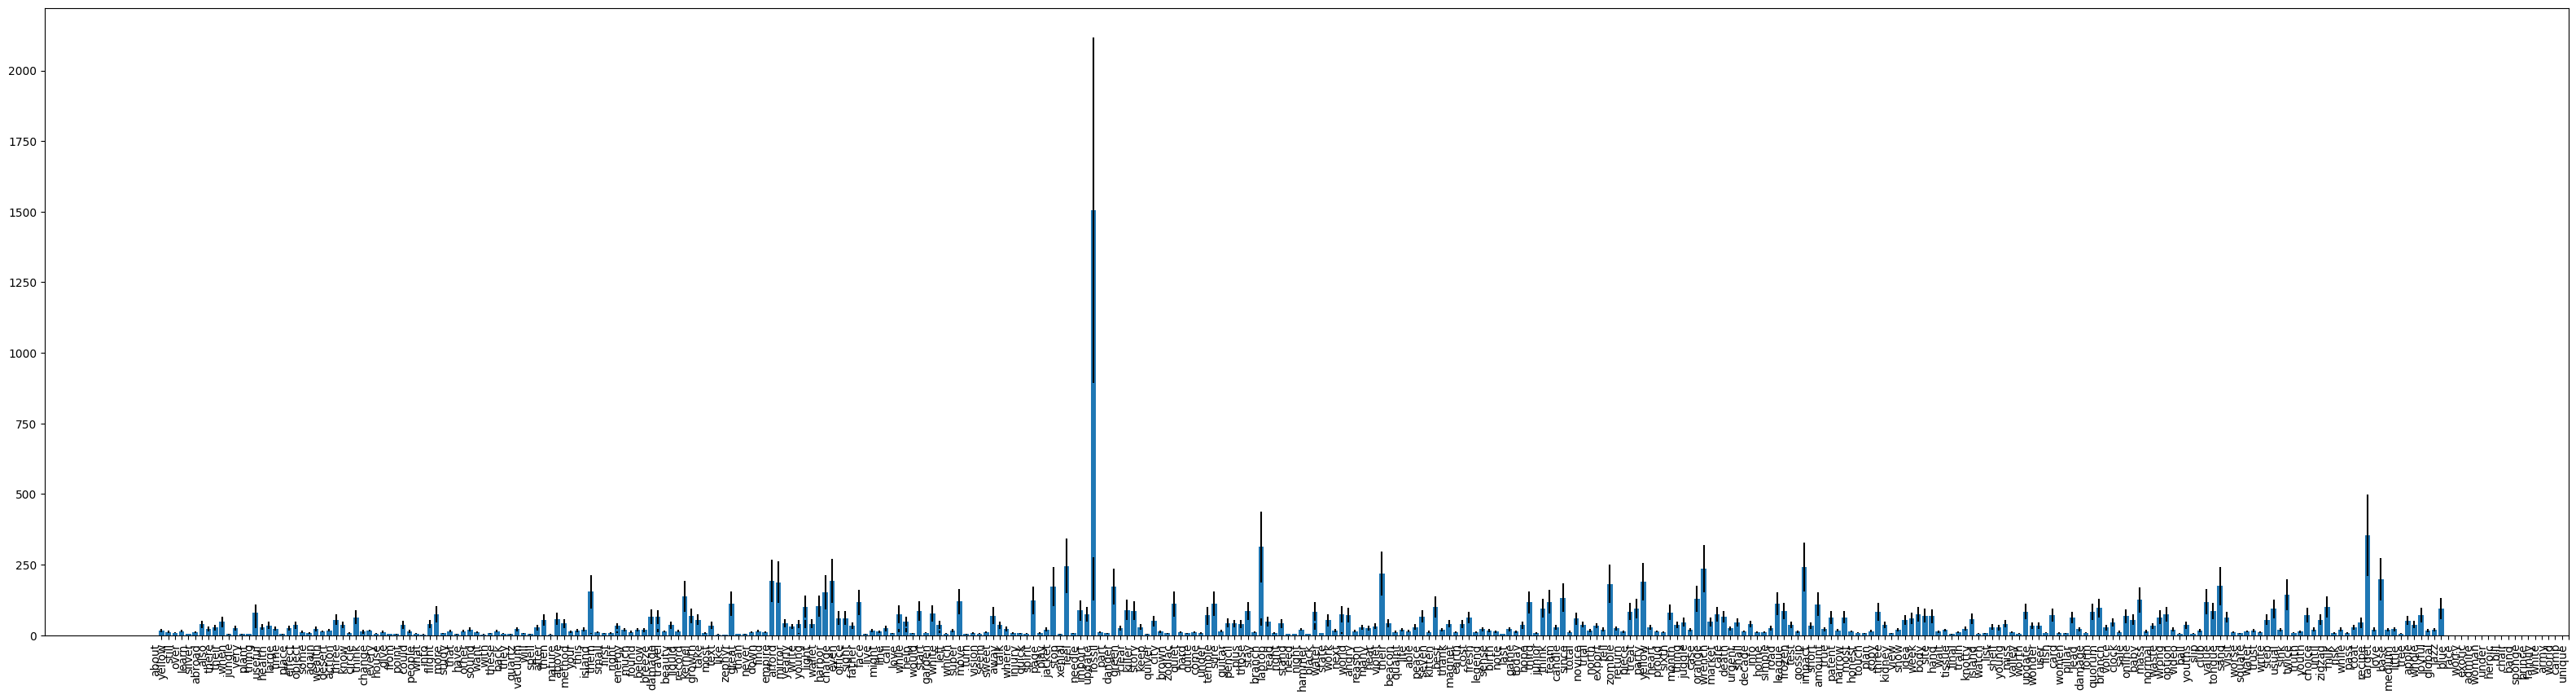

In [4]:
#make the statsdf rt cols to number instead of object
statsdf['rt_max'] = pd.to_numeric(statsdf['rt_max'])
statsdf['rt_min'] = pd.to_numeric(statsdf['rt_min'])
statsdf['rt_mean'] = pd.to_numeric(statsdf['rt_mean'])
statsdf['rt_std'] = pd.to_numeric(statsdf['rt_std'])

#lets do some visualizations I guess using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# bar plot of the max rt with error bars using the std of the rt
bar_plot = plt.bar(statsdf['correct'], statsdf['rt_max'], yerr=statsdf['rt_std'])
# space out the x axis so it's readable, and rotate the x axis labels, make horizontal
bar_plot = plt.xticks(np.arange(0, len(statsdf['correct'])), statsdf['correct'], rotation=90, ha='right')
plt.gcf().set_size_inches(40, 10)
#arrange accending order for the max rt
plt.show()



Always recomment the save file before a git push.

In [5]:
# from datetime import datetime
# now = datetime.now()
# dt_string = now.strftime("%Y%m%d_%H%M")
# timestamped = 'subject_stats' + dt_string + '.csv'
# df.to_csv(timestamped, index=False)
# subject_stats.drop(['response'], axis=1).to_csv(timestamped, index=False)